# Test Double Patterns

**Problem:** Dependencje są kosztowne, nieprzewidywalne lub niedostępne.

**Rozwiązanie:** Podstaw "dublera" (zamiennika) zamiast prawdziwego obiektu.

**Analogia:** Jak kasjer filmowy - nie potrzebujesz prawdziwego aktora do każdej sceny.

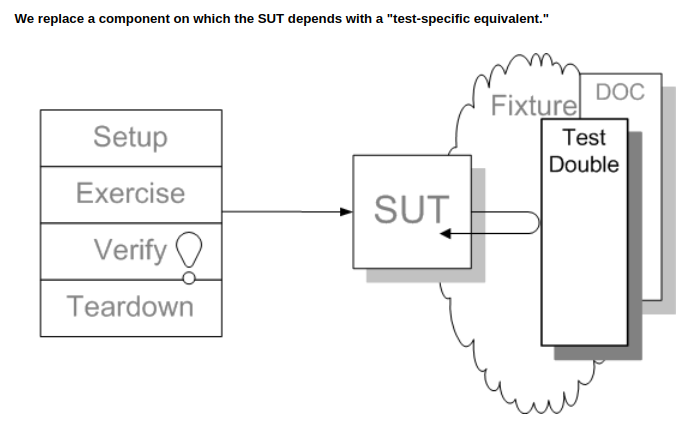

Według Martina Fowlera Test Double to ogólne określenie na każdą sytuację, w której na potrzeby testów zastępuje się obiekt produkcyjny innym obiektem.

Gerard Meszaros wyróżnił pięć typów Test Double: **Dummy**, **Stub**,  **Spy**, **Mock** oraz **Fake**.

In [ ]:
# System Under Test (SUT)
class EmailService:
    def send(self, recipient, message):
        # Kosztowne połączenie SMTP
        print(f"Sending '{message}' to {recipient}")
        return {"status": "sent", "id": "12345"}

class UserService:
    def __init__(self, email_service):
        self.email_service = email_service
    
    def register_user(self, email):
        # ... logika rejestracji ...
        result = self.email_service.send(email, "Welcome!")
        return result["status"] == "sent"

## 1. Dummy Object - Wypełniacz

In [ ]:
class DummyEmailService:
    """Dummy - never called, just fills parameter"""
    def send(self, recipient, message):
        raise Exception("Should not be called!")

def test_user_service_creation():
    # Dummy wystarczy do stworzenia obiektu
    dummy_email = DummyEmailService()
    service = UserService(dummy_email)  # Nie wywołujemy send()
    assert service is not None

## 2. Test Stub - Predefiniowane odpowiedzi

In [ ]:
class StubEmailService:
    """Stub - returns predefined responses"""
    def send(self, recipient, message):
        return {"status": "sent", "id": "stub123"}  # Zawsze sukces

def test_successful_registration():
    stub_email = StubEmailService()
    service = UserService(stub_email)
    
    result = service.register_user("test@example.com")
    
    assert result is True  # Sprawdzamy tylko wynik SUT

## 3. Test Spy - Rejestruje wywołania

In [ ]:
class SpyEmailService:
    """Spy - records how it was called"""
    def __init__(self):
        self.calls = []
        
    def send(self, recipient, message):
        self.calls.append((recipient, message))  # Rejestruj
        return {"status": "sent", "id": "spy123"}
    
    def was_called_with(self, recipient, message):
        return (recipient, message) in self.calls

def test_registration_sends_email():
    spy_email = SpyEmailService()
    service = UserService(spy_email)
    
    service.register_user("user@example.com")
    
    # Sprawdź czy email został wysłany
    assert spy_email.was_called_with("user@example.com", "Welcome!")

## 4. Mock Object - Weryfikuje interakcje

In [ ]:
from unittest.mock import Mock

def test_registration_with_mock():
    # Mock - predefiniuj odpowiedzi I weryfikuj wywołania
    mock_email = Mock()
    mock_email.send.return_value = {"status": "sent", "id": "mock123"}
    
    service = UserService(mock_email)
    service.register_user("user@example.com")
    
    # Mock automatycznie weryfikuje
    mock_email.send.assert_called_once_with("user@example.com", "Welcome!")

## 5. Fake Object - Uproszczona implementacja

In [ ]:
class FakeEmailService:
    """Fake - working implementation, but simplified"""
    def __init__(self):
        self.sent_emails = []  # In-memory storage zamiast SMTP
    
    def send(self, recipient, message):
        email = {"to": recipient, "body": message, "id": len(self.sent_emails)}
        self.sent_emails.append(email)
        return {"status": "sent", "id": str(email["id"])}
    
    def count_sent_to(self, recipient):
        return sum(1 for email in self.sent_emails if email["to"] == recipient)

def test_multiple_registrations():
    fake_email = FakeEmailService()
    service = UserService(fake_email)
    
    service.register_user("user1@example.com")
    service.register_user("user2@example.com")
    service.register_user("user1@example.com")  # Ponownie
    
    assert fake_email.count_sent_to("user1@example.com") == 2
    assert fake_email.count_sent_to("user2@example.com") == 1

## Kiedy używać czego?

| Double | Kiedy używać |
|--------|-------------|
| **Dummy** | Parametr wymagany, ale nieużywany |
| **Stub** | Potrzebujesz konkretnej odpowiedzi |
| **Spy** | Sprawdzasz czy coś zostało wywołane |
| **Mock** | Weryfikujesz interakcje (unittest.mock) |
| **Fake** | Potrzebujesz działającej, ale prostej implementacji |

**Zasada:** Użyj najprostszego double'a który rozwiąże problem!